In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
import fiona
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
import json
import datetime
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

In [2]:
with open('data/mwrd_cso.geojson', 'r') as fh:
    raw = json.loads(fh.read())

In [3]:
features_raw = raw['features']
features_raw[0:1]

[{'geometry': {'coordinates': [-87.7102367, 42.0042798], 'type': 'Point'},
  'properties': {'ACTIVE_OR_ABANDONED': 'Active',
   'ASSOCIATED_PLANT': '01 - Stickney',
   'CSO_DATE_TIME': 1467921120000,
   'CSO_EVENT': 'No',
   'CSO_GROUP': 'North Mainstream',
   'CSO_HOT_SPOT_ZONE': 'Zone 1-4-Foster Avenue',
   'GlobalID': '{4D340901-1915-418C-B003-AA85C47AD6F9}',
   'LAST_REPORTED_USER': None,
   'LINK_ID': 'DSM97_TG1',
   'LOCATION': 'Pratt Ave (E)',
   'M_OR_U': 'Monitored',
   'OBJECTID': 1475,
   'OUTFALL_CITY': 'Chicago',
   'OUTFALL_NUM': '2',
   'OUTFALL_NUM_TEXT': '2',
   'OWNER': 'Chicago',
   'REPRESENTED_OUTFALL': 'DS-M97',
   'TARP_CONNECTION': 'DS-M97',
   'TARP_CONNECTION_M': 'DSM97',
   'TIDE_GATE': '01',
   'TIDE_GATE_QE_ID': 'M97-1 or 2',
   'WATERWAY_REACH': 'NSC Lower (NSWRP)',
   'created_date': 1461699334000,
   'created_user': 'CSO',
   'last_edited_date': 1468244858000,
   'last_edited_user': 'CSO'},
  'type': 'Feature'}]

In [4]:
features = []
for feature in features_raw:
    features.append({'lat': feature['geometry']['coordinates'][1],
                    'lon': feature['geometry']['coordinates'][0],
                    'waterway_reach': feature['properties']['WATERWAY_REACH'], 
                    'associated_plant': feature['properties']['ASSOCIATED_PLANT'],
                    'tarp_connection': feature['properties']['REPRESENTED_OUTFALL']})
features[0:5]

[{'associated_plant': '01 - Stickney',
  'lat': 42.0042798,
  'lon': -87.7102367,
  'tarp_connection': 'DS-M97',
  'waterway_reach': 'NSC Lower (NSWRP)'},
 {'associated_plant': '01 - Stickney',
  'lat': 42.0033235,
  'lon': -87.7104787,
  'tarp_connection': 'DS-M97',
  'waterway_reach': 'NSC Lower (NSWRP)'},
 {'associated_plant': '01 - Stickney',
  'lat': 42.0030184,
  'lon': -87.7811785,
  'tarp_connection': 'DS-N10A',
  'waterway_reach': 'NBCR Upper (NSC Confluence)'},
 {'associated_plant': '01 - Stickney',
  'lat': 41.999744,
  'lon': -87.7885191,
  'tarp_connection': 'DS-N10B',
  'waterway_reach': 'NBCR Upper (NSC Confluence)'},
 {'associated_plant': '01 - Stickney',
  'lat': 41.9921363,
  'lon': -87.7733599,
  'tarp_connection': 'DS-N09',
  'waterway_reach': 'NBCR Upper (NSC Confluence)'}]

In [5]:
outfall_points = pd.DataFrame(features)
outfall_points.reset_index(drop=True, inplace=True)
outfall_points = outfall_points.groupby('tarp_connection').first()
outfall_points.head()

,associated_plant,lat,lon,waterway_reach
tarp_connection,,,,
18E-PS,02 - Calumet,41.651940,-87.719440,Cal Sag Ch
CDS-10,02 - Calumet,41.655983,-87.658265,Cal Sag Ch
CDS-11,02 - Calumet,41.656390,-87.654440,Cal Sag Ch
CDS-12,02 - Calumet,41.657699,-87.633974,Little Cal R (North)
CDS-13,02 - Calumet,41.662220,-87.618890,Little Cal R (North)


In [6]:
csos = pd.read_csv('data/merged_cso_data.csv')
csos['Open date/time'] = pd.to_datetime(csos['Open date/time'])
csos['Close date/time'] = pd.to_datetime(csos['Close date/time'])
csos['Duration'] = csos['Close date/time'] - csos['Open date/time']
outfall_cumulative = pd.DataFrame(csos.groupby(by=['Outfall Structure'])['Duration'].sum().sort_values(ascending=False))
outfall_cumulative['Duration_mins'] = outfall_cumulative['Duration'] / np.timedelta64(1, 'm')
outfall_cumulative.head()

,Duration,Duration_mins
Outfall Structure,,
DS-M11,87 days 17:01:00,126301.0
DS-D31,59 days 00:52:00,85012.0
"RAPS (DS-M27, DS-M28, DS-M29)",54 days 03:48:00,77988.0
DS-M15,51 days 04:56:00,73736.0
"DS-D44,45",46 days 06:37:00,66637.0


In [7]:
outfalls_with_durations = list(outfall_cumulative.index)
outfalls_with_durations[:5]

['DS-M11', 'DS-D31', 'RAPS (DS-M27, DS-M28, DS-M29)', 'DS-M15', 'DS-D44,45']

In [8]:
outfalls_with_locations = list(outfall_points.index)
outfalls_with_locations[:5]

['18E-PS', 'CDS-10', 'CDS-11', 'CDS-12', 'CDS-13']

In [9]:
# Overflows where we don't have lat/lon
len(set(outfalls_with_durations) - set(outfalls_with_locations))

33

In [10]:
# Locations where we don't have CSO data
len(set(outfalls_with_locations) - set(outfalls_with_durations))

35

In [11]:
type(outfalls_with_locations)

list

In [12]:
outfalls_with_both = list(set(outfalls_with_locations).intersection(outfalls_with_durations))
outfalls_with_both[:5]

['CDS-23', 'DS-M105W', 'TG-M22', 'CDS-15-2', 'CDS-39']

In [18]:
data_points = pd.concat([outfall_cumulative, outfall_points], axis=1, join='inner')
data_points['name'] = data_points.index
data_points.head()

,Duration,Duration_mins,associated_plant,lat,lon,waterway_reach,name
CDS-10,7 days 21:31:00,11371.0,02 - Calumet,41.655983,-87.658265,Cal Sag Ch,CDS-10
CDS-11,5 days 04:44:00,7484.0,02 - Calumet,41.656390,-87.654440,Cal Sag Ch,CDS-11
CDS-12,5 days 04:20:00,7460.0,02 - Calumet,41.657699,-87.633974,Little Cal R (North),CDS-12
CDS-14,3 days 08:16:00,4816.0,02 - Calumet,41.659129,-87.618857,Little Cal R (North),CDS-14
CDS-15-1,4 days 13:26:00,6566.0,02 - Calumet,41.651813,-87.623111,Little Cal R (North),CDS-15-1


In [20]:
data_points.to_json(orient='records')

'[{"Duration":682260000,"Duration_mins":11371.0,"associated_plant":"02 - Calumet","lat":41.6559825,"lon":-87.6582653,"waterway_reach":"Cal Sag Ch","name":"CDS-10"},{"Duration":449040000,"Duration_mins":7484.0,"associated_plant":"02 - Calumet","lat":41.65639,"lon":-87.65444,"waterway_reach":"Cal Sag Ch","name":"CDS-11"},{"Duration":447600000,"Duration_mins":7460.0,"associated_plant":"02 - Calumet","lat":41.657699,"lon":-87.633974,"waterway_reach":"Little Cal R (North)","name":"CDS-12"},{"Duration":288960000,"Duration_mins":4816.0,"associated_plant":"02 - Calumet","lat":41.6591292,"lon":-87.6188567,"waterway_reach":"Little Cal R (North)","name":"CDS-14"},{"Duration":393960000,"Duration_mins":6566.0,"associated_plant":"02 - Calumet","lat":41.6518129,"lon":-87.6231108,"waterway_reach":"Little Cal R (North)","name":"CDS-15-1"},{"Duration":44700000,"Duration_mins":745.0,"associated_plant":"02 - Calumet","lat":41.6501553,"lon":-87.6207524,"waterway_reach":"Little Cal R (North)","name":"CDS-15

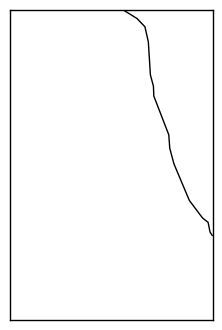

In [18]:

# make sure the value of resolution is a lowercase L,
#  for 'low', not a numeral 1
my_map = Basemap(projection='merc', lat_0=lat0, lon_0=lon0,
    resolution = 'h', area_thresh = 0.01,
    llcrnrlon=lon_min, llcrnrlat=lat_min,
    urcrnrlon=lon_max, urcrnrlat=lat_max)
 
my_map.drawcoastlines()
my_map.drawrivers()
my_map.drawmapboundary()
 
plt.show()

In [ ]:

# make sure the value of resolution is a lowercase L,
#  for 'low', not a numeral 1
my_map = Basemap(projection='merc', lat_0=lat0, lon_0=lon0,
    resolution = 'h', area_thresh = 0.01,
    llcrnrlon=lon_min, llcrnrlat=lat_min,
    urcrnrlon=lon_max, urcrnrlat=lat_max)
 
my_map.drawcoastlines()
my_map.drawrivers()
my_map.drawmapboundary()

min_marker_size = 2.5

for index, datapoint in data_points.iterrows():
    x,y = my_map(float(datapoint['lon']), float(datapoint['lat']))
    msize = datapoint['Duration_mins'] * min_marker_size
    my_map.plot(x, y, 'ro', markersize=msize)
    print(index)
plt.show()

CDS-10
CDS-11
CDS-12
CDS-14
CDS-15-1
CDS-15-2
CDS-17
CDS-18
CDS-2
CDS-20
CDS-21
CDS-22
CDS-23
CDS-39
CDS-4
CDS-41
CDS-42
CDS-43
CDS-45
CDS-5
CDS-51
CDS-53
CDS-55
CDS-6
CDS-7
CDS-8
DS-D01
DS-D02
DS-D05
DS-D06
DS-D07
DS-D08
DS-D09
DS-D10
DS-D11
DS-D12I
DS-D13
DS-D14
DS-D15
DS-D16
DS-D17
DS-D18
DS-D19,23
DS-D20I
DS-D21,25
DS-D22,24,25
DS-D26
DS-D27I
DS-D28
DS-D31
DS-D32
DS-D33
DS-D34-AI
DS-D35
DS-D36
DS-D37,38
DS-D39,42,46
DS-D40
DS-D41
DS-D44,45
DS-D47,50,51
DS-D47,50,51 & DS-13A-1
DS-D48
DS-D49
DS-D52
DS-D62
DS-D66
DS-LAT
DS-M03
DS-M08
DS-M09
DS-M10
DS-M101
DS-M104
DS-M104E
DS-M105W
DS-M106E
DS-M109N
DS-M109S
DS-M11
DS-M114N
DS-M13
DS-M15
DS-M19
DS-M20
DS-M21
DS-M25
DS-M26
DS-M27,DS-M28,& DS-M29 (RAPS)
DS-M30
DS-M38
DS-M40
DS-M41
DS-M45
DS-M47
DS-M49
DS-M51
DS-M54
DS-M61A
DS-M64
DS-M66
DS-M70
DS-M73
DS-M75
DS-M76
DS-M79
DS-M80
DS-M82
DS-M83
DS-M84
DS-M85
DS-M86
DS-M88
DS-M90 & DS-M91 (NBPS)
DS-M97
DS-N02
DS-N03
DS-N04
DS-N05
DS-N06
DS-N07
DS-N08
DS-N09
DS-N10A
DS-N10B
DS-N11
DS-N12
DS-N

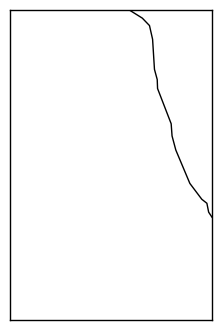

In [108]:
my_map = Basemap(projection='merc', lat_0=lat0, lon_0=lon0,
    resolution = 'h', area_thresh = 0.01,
    llcrnrlon=lon_min, llcrnrlat=lat_min,
    urcrnrlon=lon_max, urcrnrlat=lat_max)
 
my_map.drawcoastlines()
my_map.drawrivers()
my_map.drawmapboundary()

min_marker_size = 2.5
for lon, lat, mag in zip(lons, lats, magnitudes):
    x,y = eq_map(lon, lat)
    msize = mag * min_marker_size
    eq_map.plot(x, y, 'ro', markersize=msize)
 
plt.show()